In [2]:
import pwd
import pywikibot
import pandas as pd 
import numpy as np
import time 
import re
import seaborn as sns
import matplotlib.pyplot as plt 

# %matplotlib inline 

plt.rc('figure', figsize=(12, 6))

In [3]:
site = pywikibot.Site('en', 'wikipedia')  # The site we want to run our bot on

In [4]:
page = pywikibot.Page(site, 'Structural_equation_modeling')

In [5]:
print(page.full_url())  # page link 

https://en.wikipedia.org/wiki/Structural_equation_modeling


In [6]:
categories = list(page.categories())

In [7]:
text = page.text

In [8]:
def find_patten(regx,page,how="one"):
    pattern = re.compile(regx)
    result = pattern.findall(page)
    if how == "one":
        return result[0]
    elif how == "all":
        return result
    
def clean_string(text_list):
    f = lambda x: re.sub(u"{(.*)}", "", x)
    return [f(c.replace("=","")) for c in text_list]

In [9]:
topics = clean_string(find_patten(u"==(.+)==", text, 'all'))

In [10]:
topics

[' History ',

 ' General approach to SEM ',

 ' Model specification ',

 ' Estimation of free parameters ',

 ' Assessment of model and model fit ',

 ' Model modification ',

 ' Sample size and power ',

 ' Interpretation and communication ',

 ' Advanced uses ',

 ' SEM-specific software ',

 ' See also ',

 ' References ',

 ' Further reading ',

 ' External links ']

In [13]:
# from pywikibot.data import api
# import pywikibot
# import pprint

# def getItems(site, itemtitle):
#     params = { 'action' :'wbsearchentities' , 'format' : 'json' , 'language' : 'en', 'type' : 'item', 'search': itemtitle}
#     request = api.Request(site=site,**params)
#     return request.submit()

# def getItem(site, wdItem, token):
#     request = api.Request(site=site,
#                       action='wbgetentities',
#                       format='json',
#                       ids=wdItem)    
#     return request.submit()

# def prettyPrint(variable):
#     pp = pprint.PrettyPrinter(indent=4)
#     pp.pprint(variable)

# # Login to wikidata
# site = pywikibot.Site("wikidata", "wikidata")
# repo = site.data_repository()
# # token = repo.token(pywikibot.Page(repo, 'Main Page'), 'edit')
# wikidataEntries = getItems(site, "Game_of_Thrones")
# # Print the different Wikidata entries to the screen
# prettyPrint(wikidataEntries)

# # Print each wikidata entry as an object
# #for wdEntry in wikidataEntries["search"]:
# #   prettyPrint(getItem(site, wdEntry["id"], token))

# Find Contributors

In [7]:
contributors = page.contributors()

In [49]:
print("Num of contributors: %s" %len(contributors))

Num of contributors: 2810


In [120]:
edits = pd.Series(contributors)

In [121]:
print('Num of edits: %s' %sum(edits))

Num of edits: 7507


In [122]:
edits.quantile(np.arange(0,1,0.05))

0.00    1.0

0.05    1.0

0.10    1.0

0.15    1.0

0.20    1.0

0.25    1.0

0.30    1.0

0.35    1.0

0.40    1.0

0.45    1.0

0.50    1.0

0.55    1.0

0.60    1.0

0.65    1.0

0.70    1.0

0.75    2.0

0.80    2.0

0.85    2.0

0.90    3.0

0.95    5.0

dtype: float64

- less than 5% contributors edit more than 5 times

In [123]:
edits.sort_values(ascending=False)[:20]   # top 20 contributors

Sandstein            627

Drovethrughosts      410

AffeL                377

AlexTheWhovian       202

Mirlen               197

Trut-h-urts man      170

ClueBot NG           146

TAnthony              89

Caidh                 70

Hzh                   65

Darkwarriorblake      44

Emir of Wikipedia     41

Hijiri88              37

Miniapolis            36

77.166.229.180        34

Xeworlebi             30

Padenton              29

Yoenit                28

Amalthea              26

Hyliad                24

dtype: int64

## Contributors Type 

In [153]:
### identify anonymous user and bot account 
def identify_users(user_name):
    if 'bot' in user_name.lower():
        return "bot"
    elif re.findall(u"\d+\.\d+\.\d+\.\d+", user_name):
        return "anonymous"
    else:
        return "registered"
user_type = pd.Series(edits.index).apply(identify_users)

In [154]:
edits_counts = edits.groupby(user_type.values).agg(sum).sort_values()
edits_summary = pd.DataFrame([user_type.value_counts(),edits_counts]).T
edits_summary.columns = ['user_count', 'edit_count']
edits_summary

,user_count,edit_count
anonymous,1522,2294
bot,46,276
registered,1242,4937


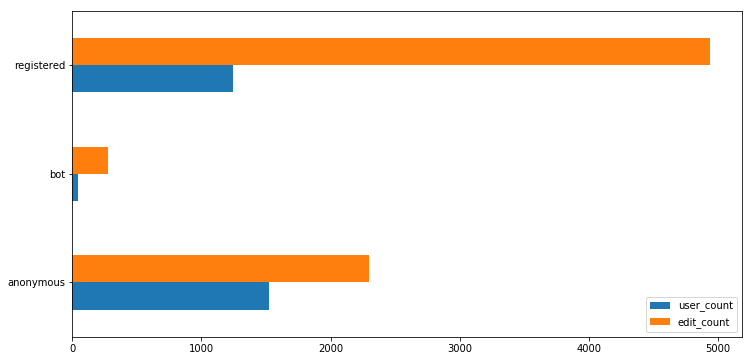

In [155]:
edits_summary.plot.barh()

- registered user made far more edits than the anonymous ones, though they are less in numbers

# Revision history

In [63]:
revisions = page.revisions(content=True)

In [65]:
revisions = pd.DataFrame([c.__dict__ for c in revisions])

In [107]:
# backup revision
revisions.to_csv("backup.csv")

In [68]:
revisions['text_length'] = revisions['text'].apply(get_len)

In [64]:
def get_len(x):
    try:
        return len(x)
    except:
        return None

In [69]:
lags = []
for i in range(len(revisions)):
    if i != len(revisions)-1:
        lags.append(revisions['text_length'][i] - revisions['text_length'][i+1])
    else:
        lags.append(revisions['text_length'][i] - 0)

In [70]:
revisions['length_change'] = lags

In [109]:
test = revisions[['text_length','length_change']]
test.index = revisions['timestamp']

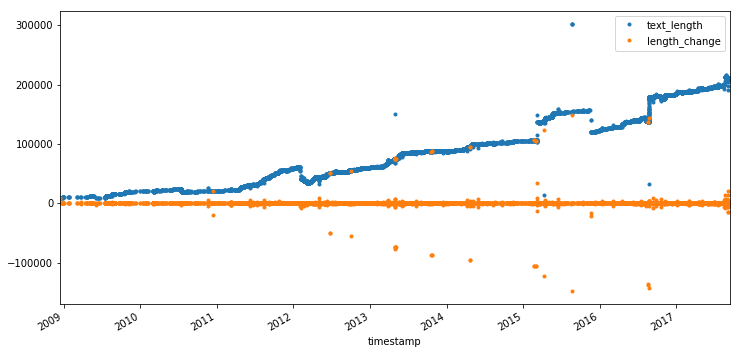

In [110]:
test.plot(style='.')

- How to evaluate one's contribution? it can not evaluate by their edits number, should be someting combine the edits and content changes
- How to detect attack? propose that one attack should be when 80% of the content were removed.

# Talk pages

In [161]:
talk = page.toggleTalkPage()
talk = talk.revisions(content=True)
talk = pd.DataFrame([c.__dict__ for c in talk])
# backup talks
talk.to_csv("backup_talk.csv")

In [164]:
talk.head()

,_content_model,_parent_id,_sha1,anon,comment,minor,revid,rollbacktoken,text,timestamp,user
0,wikitext,798734943,bc1f301a109e29345f1dea072cbcf00830abb41c,False,/* Why not semi-protect? */,False,798824081,None,{{Old peer review|archive=2}}\n{{Talk header}}...,2017-09-04 01:25:22,Hijiri88
1,wikitext,798727449,26e1f433d0ed84c8147fd27664b3b71e493b895d,False,/* Why not semi-protect? */,False,798734943,None,{{Old peer review|archive=2}}\n{{Talk header}}...,2017-09-03 14:23:54,Emir of Wikipedia
2,wikitext,798721116,7d5dd36dfc1059e10a9ebeb9af49d792956d8475,False,/* Why not semi-protect? */ re,False,798727449,None,{{Old peer review|archive=2}}\n{{Talk header}}...,2017-09-03 13:16:25,IVORK
3,wikitext,798719633,98d28b78b63f0a3796f3ffbcbfdfce203447b1aa,False,/* Why not semi-protect? */,False,798721116,None,{{Old peer review|archive=2}}\n{{Talk header}}...,2017-09-03 12:11:00,Hijiri88
4,wikitext,798715960,57fcbf3e3a83348fc01df9c338f23deb3e8ca70e,False,/* Why not semi-protect? */ reply,False,798719633,None,{{Old peer review|archive=2}}\n{{Talk header}}...,2017-09-03 11:56:19,Emir of Wikipedia


In [165]:
len(talk)

926

In [172]:
talk_users = set(talk['user'])
sum([1 for c in edits.sort_values(ascending=False)[:20].index if c in talk_users] )

17

- 17 out of 20 most edits users were in the talk page 

## user' talk frequent

In [296]:
g = talk.groupby(pd.Grouper(key = 'timestamp', freq='1d'))
talk_freq = g.agg({'revid':len, 'user': lambda x: len(np.unique(x))})
talk_freq.tail()

,revid,user
timestamp,,
2017-08-31,0,0
2017-09-01,0,0
2017-09-02,0,0
2017-09-03,5,3
2017-09-04,1,1


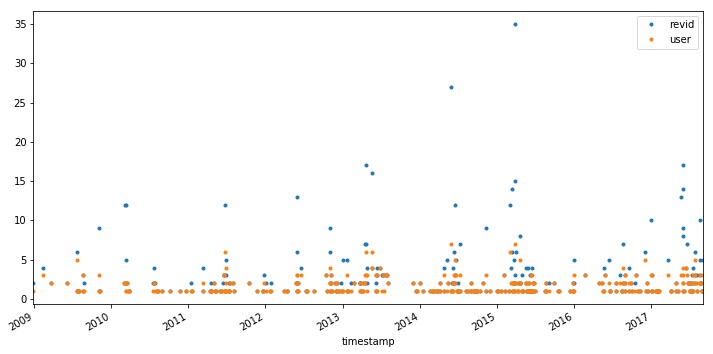

In [297]:
mask = talk_freq.apply(sum, 1) != 0
talk_freq2 = talk_freq[mask]
talk_freq2.plot(style='.')

In [1]:
mask = (talk_freq2['user'] == 1) & (talk_freq2['revid']>1)
print("talk to one's slef %s" %sum(mask))
# talk_freq2[mask]

NameError: name 'talk_freq2' is not defined

- only 40 users talk to himself in a day

## combine both 

## define talk intense degree

$$talk\;intense = \log(talk\;number * talk\;user\;number+1)$$

In [298]:
talk_intense = np.log(talk_freq['revid'] * talk_freq['user']+1)

In [299]:
def date2string(date, reverse = False):
    if reverse:
        return pd.to_datetime(date)
    else:
        return "-".join([str(c) for c in [date.year, date.month, date.day]])

In [300]:
talk_intense.index = pd.Series(talk_intense.index).apply(date2string)

In [301]:
map_dict = talk_intense.to_dict()

In [302]:
test = test.reset_index()
test.head()

,index,timestamp,text_length,length_change
0,0,2017-09-12 20:16:38,211640,-16
1,1,2017-09-12 20:16:06,211656,16
2,2,2017-09-11 23:56:09,211640,14
3,3,2017-09-11 23:55:59,211626,-14
4,4,2017-09-11 16:44:28,211640,-25


In [303]:
g = test.groupby(pd.Grouper(key='timestamp', freq='1d'))
test2 = g.agg(np.mean)

In [304]:
test2.index = pd.Series(test2.index).apply(date2string)
test2 = test2.reset_index()

In [305]:
test2.dropna(inplace=True)
test2['talk_intense'] = test2['timestamp'].map(map_dict)

In [306]:
test2.head()

,timestamp,index,text_length,length_change,talk_intense
0,2008-12-15,7506.0,9110.000000,9110.000000,NaN
1,2008-12-16,7504.0,9162.333333,24.333333,NaN
11,2008-12-26,7501.5,9417.000000,121.000000,NaN
14,2008-12-29,7495.0,10642.454545,134.000000,1.098612
15,2008-12-30,7487.5,10846.000000,-32.750000,0.000000


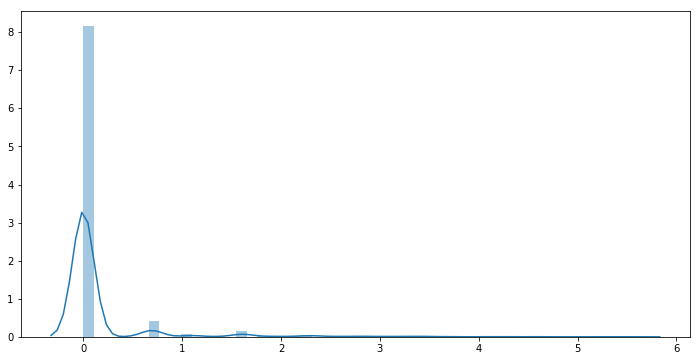

In [312]:
sns.distplot(talk_intense)

In [307]:
test2.index = pd.to_datetime(test2['timestamp'])

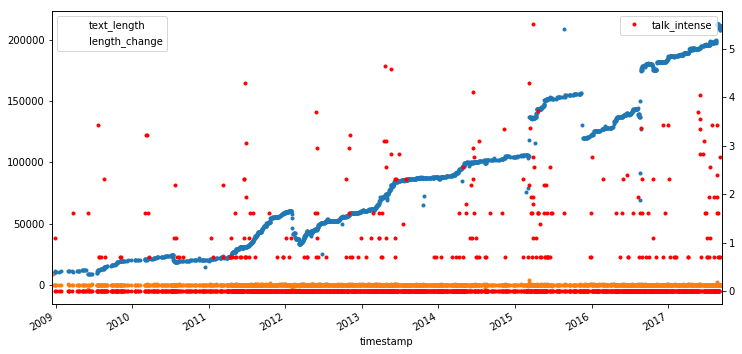

In [308]:
fig, ax = plt.subplots()
test2[['text_length','length_change']].plot(ax=ax, style='.', legend=True)
test2['talk_intense'].plot(ax=ax, style='r.', secondary_y=True)
plt.legend()

In [315]:
# if we remove less intensive talk record
test2['talk_intense2'] = np.where(test2['talk_intense']>1, test2['talk_intense'], [np.nan]*len(test2))

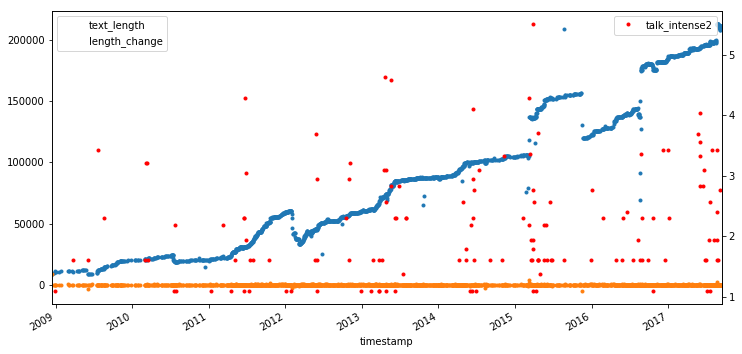

In [316]:
fig, ax = plt.subplots()
test2[['text_length','length_change']].plot(ax=ax, style='.')
test2['talk_intense2'].plot(ax=ax, style='r.', secondary_y=True)
plt.legend()

In [332]:
test2['timestamp'] = pd.to_datetime(test2['timestamp'])

In [333]:
g = test2.reset_index(drop=True).groupby(pd.Grouper(key='timestamp', freq='30d'))
test3 = g.agg(np.mean)

In [357]:
test3 = test3.sort_index(ascending=False)
test3 = test3.iloc[0:len(test3)-1,:]

In [341]:
lags = []
for i in range(len(test3)):
    if i != len(test3)-1:
        lags.append(test3['text_length'][i] - test3['text_length'][i+1])
    else:
        lags.append(test3['text_length'][i] - 0)
test3['length_change'] = lags

In [359]:
test3.tail()

,index,text_length,length_change,talk_intense,talk_intense2
timestamp,,,,,
2009-05-14,7444.333333,10228.583333,-1232.560884,0.268240,1.609438
2009-04-14,7465.071429,11461.144218,674.144218,0.000000,NaN
2009-03-15,7475.250000,10787.000000,-377.333333,0.804719,1.609438
2009-02-13,7478.000000,11164.333333,297.083333,0.000000,NaN
2009-01-14,7482.750000,10867.250000,876.285354,0.000000,NaN
